In [1]:
import sys
sys.path.append(r"C:\Users\HWANG\Workspace\BPM4pickup\ML\models")
from BPMQ_model import BPMQ_model, train

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
_dtype = torch.float32

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="To copy construct from a tensor")

In [3]:
BPMs = ['BDS_BTS:BPM_D5513','BDS_BTS:BPM_D5565']

In [4]:
data_path = '../../train_data/BDSentrance/'
training_data = pickle.load(open(data_path+'BDS_beamQ_training_data_from_ISAAC_filtered.pkl','rb'))

In [5]:
for k,v in training_data.items():
    print(f'{k}:   \t type={type(v).__name__}, \t lenth={len(v)}')

rel_path:   	 type=list, 	 lenth=31
n_data:   	 type=list, 	 lenth=31
measurement:   	 type=list, 	 lenth=31
simulation:   	 type=list, 	 lenth=31
fit_result:   	 type=list, 	 lenth=31
image:   	 type=list, 	 lenth=31


In [6]:
lrelpath = []
lmeas  = []
lsim   = []
lfmeas = []
lfsim  = []
for relpath, meas, sim in zip(training_data['rel_path'],training_data['measurement'],training_data['simulation']):
    if meas['BDS_BTS:BPM_D5513']['Q_err'].mean() > 1 or meas['BDS_BTS:BPM_D5565']['Q_err'].mean() > 1 :
        continue
    lrelpath.append(relpath)
    mask1 = meas.notna().all(axis=1)
    mask2 = sim.notna().all(axis=1)
    combined_mask = mask1 & mask2
    filtered_meas, filtered_sim = meas[combined_mask], sim[combined_mask]
    lmeas.append(meas)
    lsim.append(sim)
    lfmeas.append(filtered_meas)
    lfsim.append(filtered_sim)

meas = pd.concat(lmeas,axis=0,ignore_index=True)
sim  = pd.concat(lsim,axis=0,ignore_index=True) 
filtered_meas = pd.concat(lfmeas,axis=0,ignore_index=True)
filtered_sim  = pd.concat(lfsim,axis=0,ignore_index=True)

# visualize data

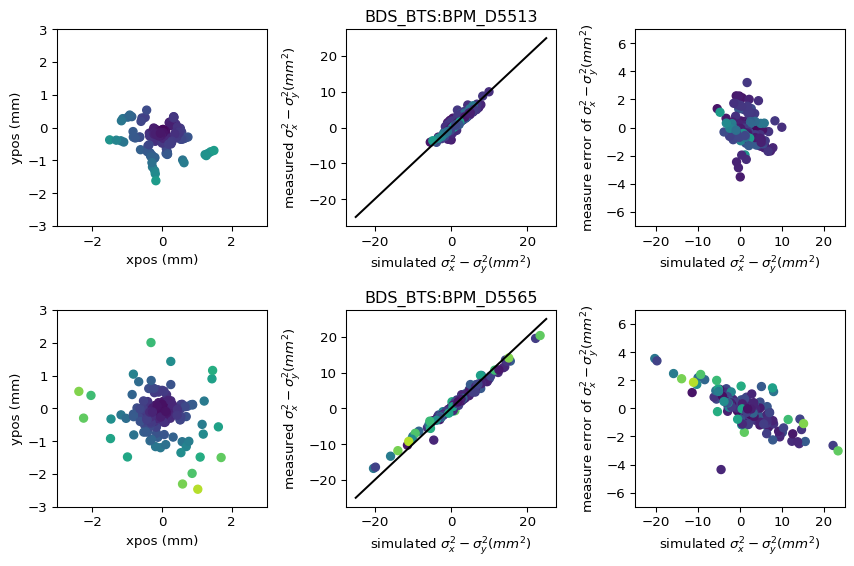

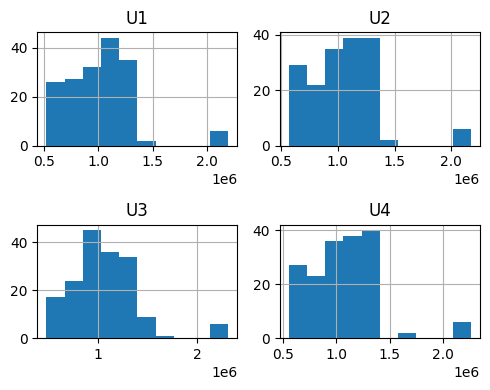

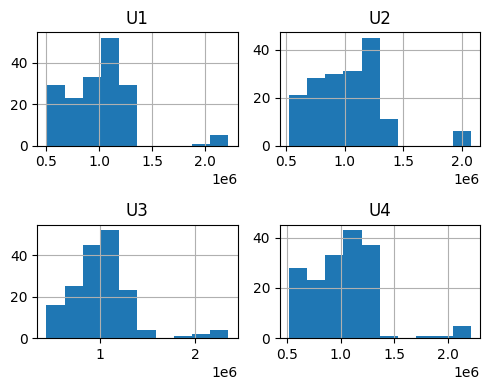

In [7]:
xpos = {}
ypos = {}
qmeas = {}
qsim = {}
diff = {}
U = {}
for bpm in BPMs:
    xpos[bpm] = filtered_meas[bpm]['XPOS'].astype(float)
    ypos[bpm] = filtered_meas[bpm]['YPOS'].astype(float)
    qmeas[bpm] = filtered_meas[bpm]['beamQ'].astype(float)
    qsim[bpm] = filtered_sim[bpm]['beamQ'].astype(float)
    U[bpm] = filtered_meas[bpm][['U1','U2','U3','U4']].astype(float)
    

fig, ax = plt.subplots(2, 3, figsize=(9, 6),dpi=96)
for i, bpm in enumerate(BPMs):
    c = (xpos[bpm]**2 + ypos[bpm]**2)**0.5

    # First subplot in the row
    ax[i, 0].scatter(xpos[bpm], ypos[bpm], c=c, vmin=0, vmax=3)
    ax[i, 0].set_xlim(-3, 3)
    ax[i, 0].set_ylim(-3, 3)
    ax[i, 0].set_xlabel('xpos (mm)')
    ax[i, 0].set_ylabel('ypos (mm)')

    # Second subplot in the row
    ax[i, 1].scatter(qsim[bpm], qmeas[bpm], c=c, vmin=0, vmax=3)
    ax[i, 1].plot([-25, 25], [-25, 25], color='k')
    ax[i, 1].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i, 1].set_ylabel('measured $\sigma_x^2-\sigma_y^2 (mm^2)$')

    # Third subplot in the row
    ax[i, 2].scatter(qsim[bpm], qmeas[bpm] - qsim[bpm], c=c, vmin=0, vmax=3)
    ax[i, 2].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i, 2].set_ylabel('measure error of $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i, 2].set_xlim(-25, 25)
    ax[i, 2].set_ylim(-7, 7)
    
    # Set a single title for each row on the first subplot
    ax[i, 1].set_title(bpm)

plt.tight_layout()

for bpm in BPMs:
    U[bpm].hist(figsize=(5,4));
    plt.tight_layout()

# discard outlier

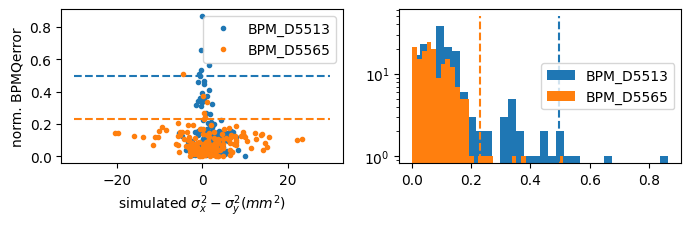

In [8]:
masks = {}
fig,ax = plt.subplots(1,2,figsize=(8,2))
n_data_ = len(filtered_sim[bpm])
n_data  = int(0.97*n_data_)
for i,bpm in enumerate(BPMs):
    loss =  np.sqrt((filtered_meas[bpm]['beamQ']-filtered_sim[bpm]['beamQ'])**2/(np.abs(filtered_sim[bpm]['beamQ'])+4)**2)
    cut = np.sort(loss)[n_data] 
    ax[0].plot(filtered_sim[bpm]['beamQ'],loss,'.',label=bpm[8:])
    ax[0].plot([-30,30],[cut,cut],c='C'+str(i),ls='--')
    ax[1].hist(loss,label=bpm[8:],bins=32)
    ax[1].plot([cut,cut],[0,50],c='C'+str(i),ls='--')
    masks[bpm] = loss < cut

ax[0].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
ax[0].set_ylabel('norm. BPMQerror')
ax[0].legend()
ax[1].legend()
ax[1].set_yscale('log')

In [9]:
filtered_meas_backup = filtered_meas
filtered_sim_backup  = filtered_sim
filtered_meas = {}
filtered_sim  = {}
for bpm in BPMs:
    filtered_meas[bpm] = filtered_meas_backup[bpm][masks[bpm]]
    filtered_sim [bpm] = filtered_sim_backup [bpm][masks[bpm]]

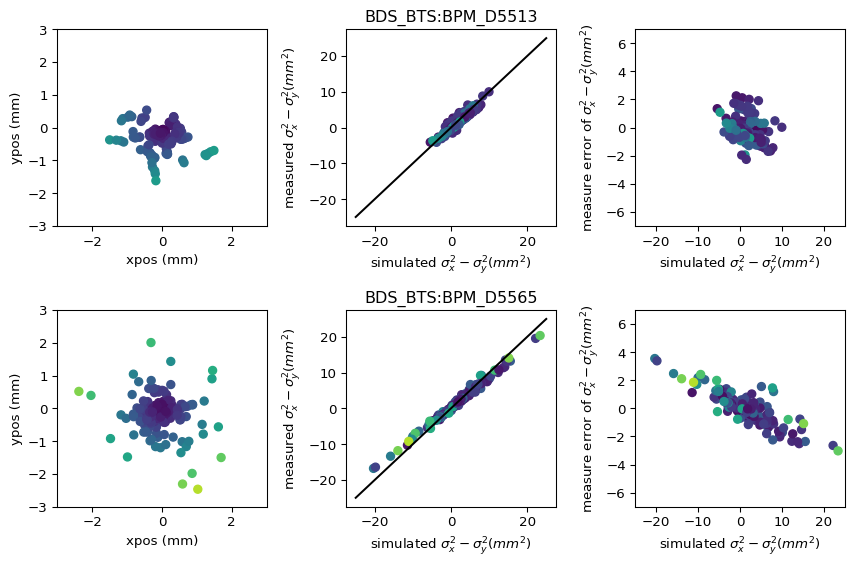

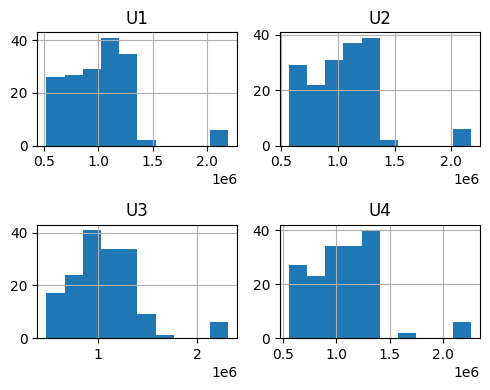

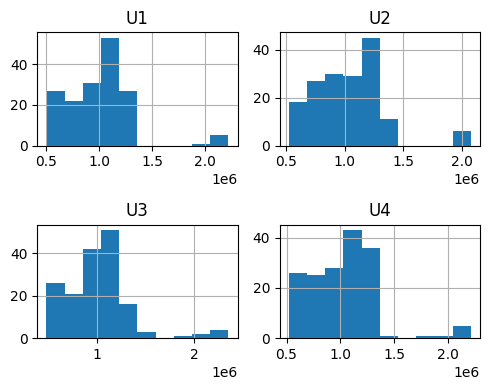

In [10]:
xpos = {}
ypos = {}
qmeas = {}
qsim = {}
diff = {}
U = {}
for bpm in BPMs:
    xpos[bpm] = filtered_meas[bpm]['XPOS'].astype(float)
    ypos[bpm] = filtered_meas[bpm]['YPOS'].astype(float)
    qmeas[bpm] = filtered_meas[bpm]['beamQ'].astype(float)
    qsim[bpm] = filtered_sim[bpm]['beamQ'].astype(float)
    U[bpm] = filtered_meas[bpm][['U1','U2','U3','U4']].astype(float)
    

fig, ax = plt.subplots(2, 3, figsize=(9, 6),dpi=96)
for i, bpm in enumerate(BPMs):
    c = (xpos[bpm]**2 + ypos[bpm]**2)**0.5

    # First subplot in the row
    ax[i, 0].scatter(xpos[bpm], ypos[bpm], c=c, vmin=0, vmax=3)
    ax[i, 0].set_xlim(-3, 3)
    ax[i, 0].set_ylim(-3, 3)
    ax[i, 0].set_xlabel('xpos (mm)')
    ax[i, 0].set_ylabel('ypos (mm)')

    # Second subplot in the row
    ax[i, 1].scatter(qsim[bpm], qmeas[bpm], c=c, vmin=0, vmax=3)
    ax[i, 1].plot([-25, 25], [-25, 25], color='k')
    ax[i, 1].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i, 1].set_ylabel('measured $\sigma_x^2-\sigma_y^2 (mm^2)$')

    # Third subplot in the row
    ax[i, 2].scatter(qsim[bpm], qmeas[bpm] - qsim[bpm], c=c, vmin=0, vmax=3)
    ax[i, 2].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i, 2].set_ylabel('measure error of $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i, 2].set_xlim(-25, 25)
    ax[i, 2].set_ylim(-7, 7)
    
    # Set a single title for each row on the first subplot
    ax[i, 1].set_title(bpm)

plt.tight_layout()

for bpm in BPMs:
    U[bpm].hist(figsize=(5,4));
    plt.tight_layout()

# train model

In [11]:
all_U = {}
all_X = {}
all_Y = {}
all_Q = {}
all_Qerr = {}
all_Qmeas = {}
np.random.seed(0)
p = np.random.permutation(np.arange(n_data))
for bpm in BPMs:
    all_U   [bpm] = torch.tensor(filtered_meas[bpm][['U1','U2','U3','U4']].values[p],dtype=_dtype)
    all_X   [bpm] = torch.tensor(filtered_meas[bpm]['XPOS'].values[p],dtype=_dtype)
    all_Y   [bpm] = torch.tensor(filtered_meas[bpm]['YPOS'].values[p],dtype=_dtype)
    all_Q   [bpm] = torch.tensor(filtered_sim [bpm]['beamQ'].values[p],dtype=_dtype)
    all_Qerr[bpm] = torch.tensor(filtered_meas[bpm]['beamQ_err'].values[p],dtype=_dtype)
    all_Qmeas[bpm] = torch.tensor(filtered_meas[bpm]['beamQ'].values[p],dtype=_dtype)
    
n_train = int(0.7*n_data) - 1
n_val = n_data - n_train
n_train, n_val

(115, 51)

In [12]:
train_U = {}
train_X = {}
train_Y = {}
train_Q = {}
train_Qerr = {}

val_U = {}
val_X = {}
val_Y = {}
val_Q = {}
val_Qerr = {}
val_Qmeas = {}

for bpm in BPMs:
    val_U   [bpm] = all_U   [bpm][:n_val]
    val_X   [bpm] = all_X   [bpm][:n_val]
    val_Y   [bpm] = all_Y   [bpm][:n_val]
    val_Q   [bpm] = all_Q   [bpm][:n_val]
    val_Qerr[bpm] = all_Qerr[bpm][:n_val]
    val_Qmeas[bpm] = all_Qmeas[bpm][:n_val]
    
    train_U   [bpm] = all_U   [bpm][n_val:]
    train_X   [bpm] = all_X   [bpm][n_val:]
    train_Y   [bpm] = all_Y   [bpm][n_val:]
    train_Q   [bpm] = all_Q   [bpm][n_val:]
    train_Qerr[bpm] = all_Qerr[bpm][n_val:]

In [13]:
models = {}
history = {}

for bpm in BPMs:
    fname = bpm.replace('_D','')[-7:]
    model_info = {'n_node':8,
                  'n_hidden_layer':4,
                  'dtype':_dtype}
    model = BPMQ_model(**model_info)
    hist_,_,_ = train(
        model,epochs=10000,lr=2e-4,
        train_U=train_U[bpm],
        train_X=train_X[bpm], 
        train_Y=train_Y[bpm],
        train_Q=train_Q[bpm],
        val_U=val_U[bpm],
        val_X=val_X[bpm],
        val_Y=val_Y[bpm],
        val_Q=val_Q[bpm],
        batch_size = int(0.1*len(train_U)),
        fname_model = fname+'/model.pt',
        fname_history = fname+'/history.pkl',
    )
    models[bpm] = model
    history[bpm] = hist_

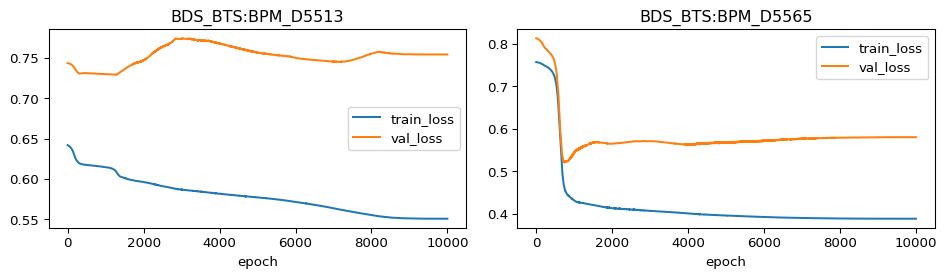

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,3),dpi=96)
for i, bpm in enumerate(BPMs):
    ax[i].set_title(bpm)
    ax[i].plot(history[bpm]['train_loss'],label='train_loss')
    ax[i].plot(history[bpm]['val_loss'],label='val_loss')
    ax[i].set_xlabel('epoch')
    ax[i].legend()

plt.tight_layout()

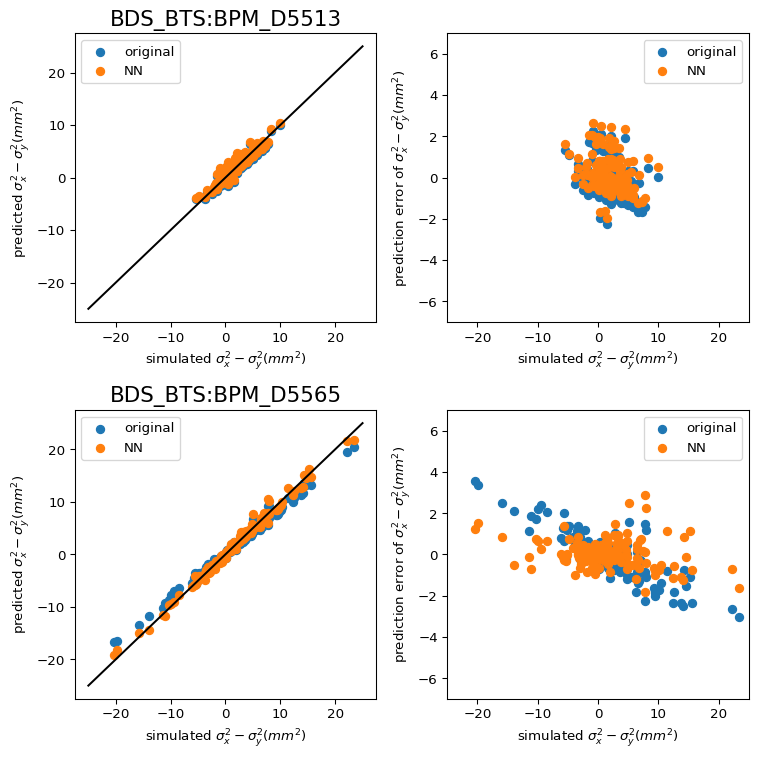

In [15]:
all_Qpred = {}
with torch.no_grad():
    for bpm in BPMs:
        model = models[bpm]
        all_Qpred[bpm] = model(all_U[bpm],all_X[bpm],all_Y[bpm]).view(-1).detach()
        
fig, ax = plt.subplots(2, 2, figsize=(8, 8),dpi=96)
for i, bpm in enumerate(BPMs):

    ax[i,0].scatter(all_Q[bpm], all_Qmeas[bpm],label='original')
    ax[i,0].scatter(all_Q[bpm], all_Qpred[bpm],label='NN')
    ax[i,0].plot([-25, 25], [-25, 25], color='k')
    ax[i,0].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,0].set_ylabel('predicted $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,0].legend()

    # Second subplot in the row
    ax[i,1].scatter(all_Q[bpm], all_Qmeas[bpm]-all_Q[bpm],label='original')
    ax[i,1].scatter(all_Q[bpm], all_Qpred[bpm]-all_Q[bpm],label='NN')
    ax[i,1].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,1].set_ylabel('prediction error of $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,1].set_xlim(-25,25)
    ax[i,1].set_ylim(-7, 7)
    ax[i,1].legend()
    
    # Set a single title for each row on the first subplot
    ax[i, 0].set_title(bpm, fontsize=16)

plt.tight_layout()

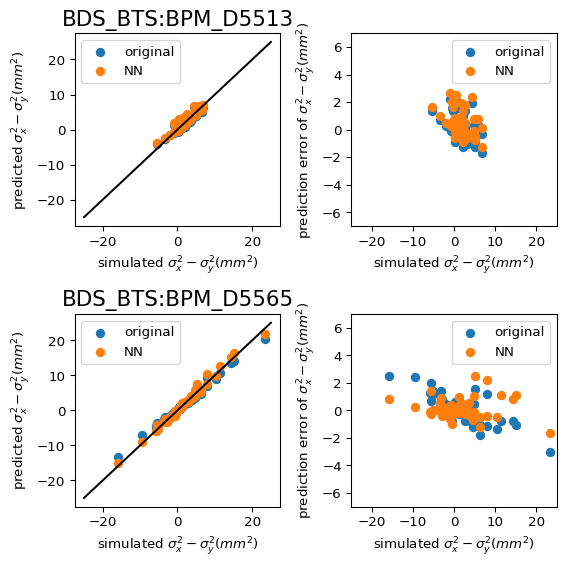

In [16]:
val_Qpred = {}
with torch.no_grad():
    for bpm in BPMs:
        model = models[bpm]
        val_Qpred[bpm] = model(val_U[bpm],val_X[bpm],val_Y[bpm]).view(-1).detach()
        
fig, ax = plt.subplots(2, 2, figsize=(6, 6),dpi=96)
for i, bpm in enumerate(BPMs):

    ax[i,0].scatter(val_Q[bpm], val_Qmeas[bpm],label='original')
    ax[i,0].scatter(val_Q[bpm], val_Qpred[bpm],label='NN')
    ax[i,0].plot([-25, 25], [-25, 25], color='k')
    ax[i,0].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,0].set_ylabel('predicted $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,0].legend()

    # Second subplot in the row
    ax[i,1].scatter(val_Q[bpm], val_Qmeas[bpm]-val_Q[bpm],label='original')
    ax[i,1].scatter(val_Q[bpm], val_Qpred[bpm]-val_Q[bpm],label='NN')
    ax[i,1].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,1].set_ylabel('prediction error of $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,1].set_xlim(-25,25)
    ax[i,1].set_ylim(-7, 7)
    ax[i,1].legend()
    
    # Set a single title for each row on the first subplot
    ax[i, 0].set_title(bpm, fontsize=16)

plt.tight_layout()